In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import hydra
from mmda.utils.spearman_utils import spearman_rank_coefficient
from mmda.utils.calibrate import get_non_conformity_scores, calibrate

def load_sim_mat_cali(config_path:str="../config", config_name:str="main")->dict:
    """Load the similarity matrix for calibration."""
    with hydra.initialize(version_base=None, config_path=config_path):
        cfg = hydra.compose(config_name=config_name)
        cfg_dataset = cfg["KITTI"]
        return joblib.load(
                Path(
                    cfg_dataset.paths.save_path,
                    f"sim_mat_cali_{cfg_dataset.retrieval_dim}_{cfg_dataset.mask_ratio}.pkl",
                )
                )

def overlap_ratio(hist1:np.ndarray, hist2:np.ndarray)->float:
    """Computes the overlap ratio between two histograms."""
    minima = np.minimum(hist1, hist2)
    intersection = np.sum(minima)
    union = np.sum(hist1) + np.sum(hist2) - intersection
    return intersection / union


### NC C Distributions Overlap Ratio

410 187
Image-Image  Overlap Ratio:  0.9249309565654027
410 187
Image-Lidar  Overlap Ratio:  0.9249309565654027
387 210
Image-Text  Overlap Ratio:  0.8887920515949103
422 175
Lidar-Lidar  Overlap Ratio:  0.892667674722571
410 187
Lidar-Text  Overlap Ratio:  0.8041910319916225
412 185
Text-Text  Overlap Ratio:  0.8159298124892481


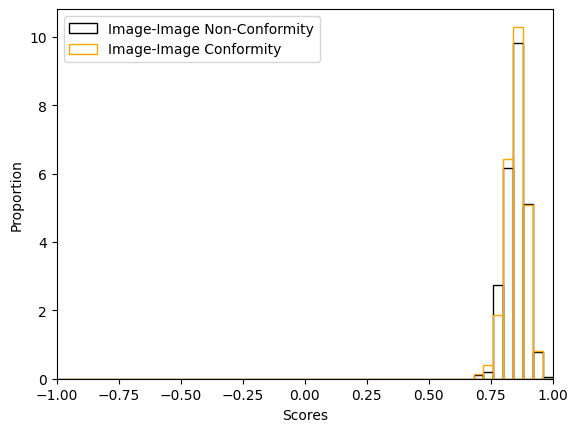

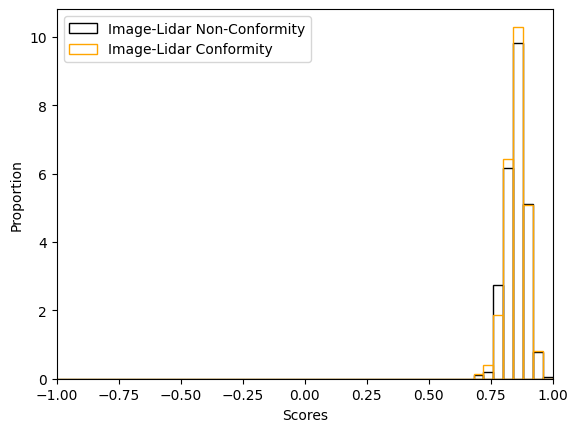

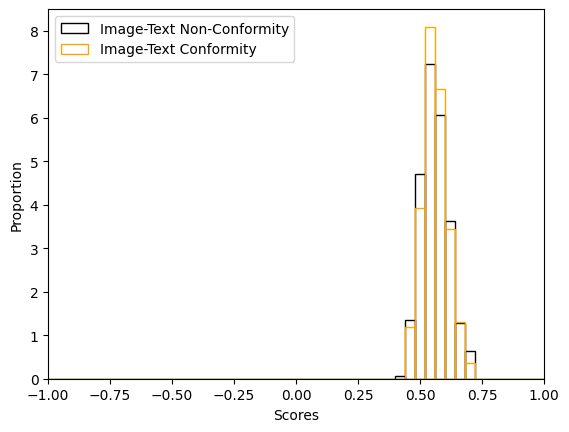

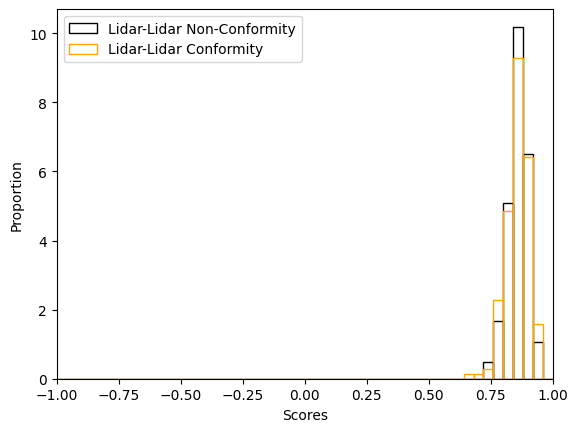

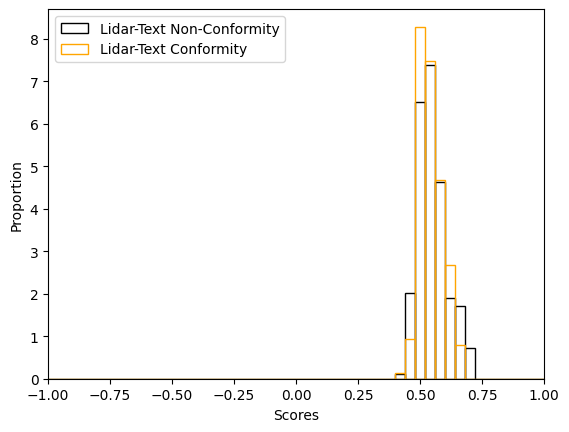

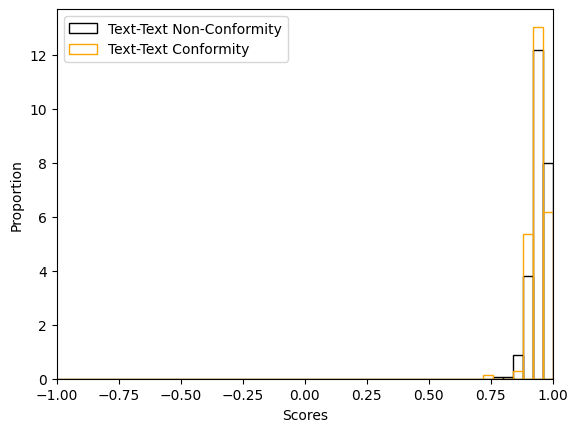

In [2]:
IMAGE = 0
LIDAR = 1
TEXT = 2

bin_edges = np.array(range(51))/25-1
modalities = ["Image", "Lidar", "Text"]

data = load_sim_mat_cali()

for i in range(3):
    for j in range(i, 3):
        plt.figure()
        nc_scores, c_scores = get_non_conformity_scores(data, i, j)
        print(len(nc_scores), len(c_scores))
        nc_fig = plt.hist(nc_scores, bins=bin_edges, fill=None, edgecolor="black", density=True, \
                        label=modalities[i] + "-" + modalities[j]+" Non-Conformity")
        c_fig = plt.hist(c_scores, bins=bin_edges, fill=None, edgecolor="orange", density=True, \
                        label=modalities[i] + "-" + modalities[j]+" Conformity")
        plt.xlabel("Scores")
        plt.ylabel("Proportion")
        plt.xlim(-1,1)
        plt.legend()
        plt.plot()

        print(modalities[i] + "-" + modalities[j], " Overlap Ratio: ", overlap_ratio(nc_fig[0], c_fig[0]))

### Nonconformity distributions

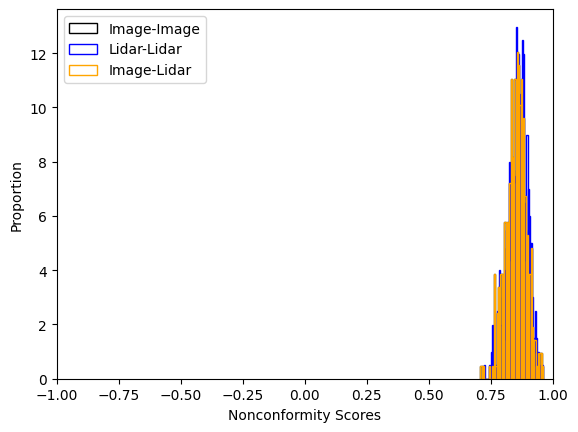

In [3]:
nc_scores_0, _ = get_non_conformity_scores(data, IMAGE, IMAGE)
plt.hist(nc_scores_0, bins=50, fill=None, edgecolor="black", density=True, label="Image-Image")

nc_scores_1, _ = get_non_conformity_scores(data, LIDAR, LIDAR)
plt.hist(nc_scores_1, bins=50, fill=None, edgecolor="blue", density=True, label = "Lidar-Lidar")

nc_scores, _ = get_non_conformity_scores(data, IMAGE, LIDAR)
plt.hist(nc_scores, bins=50, fill=None, edgecolor="orange", density=True, label = "Image-Lidar")

plt.xlabel("Nonconformity Scores")
plt.ylabel("Proportion")
plt.xlim(-1,1)
plt.legend()

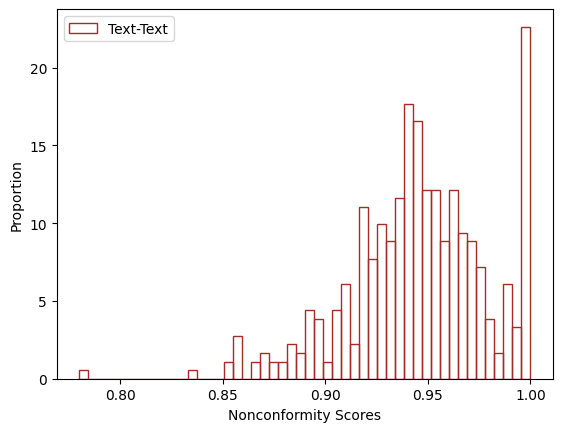

In [4]:
nc_scores_22, c_scores_22= get_non_conformity_scores(data, TEXT, TEXT)
plt.hist(nc_scores_22, bins=50, fill=None, edgecolor="brown", density=True, label = "Text-Text")
plt.xlabel("Nonconformity Scores")
plt.ylabel("Proportion")
plt.legend(title="Similarity of negative pairs")
plt.legend()

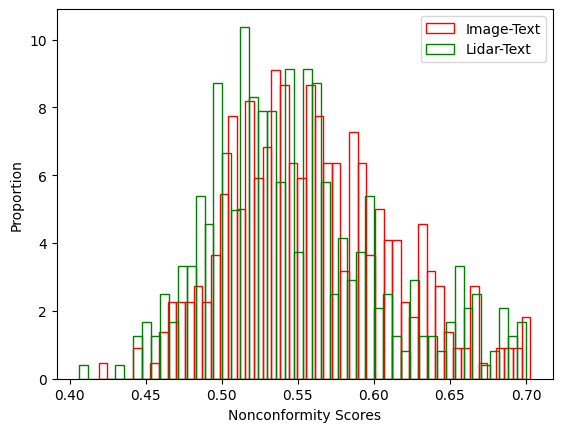

In [5]:
nc_scores_33, c_scores_33 = get_non_conformity_scores(data, IMAGE, TEXT)
plt.hist(nc_scores_33, bins=50, fill=None, edgecolor="red", density=True, label="Image-Text")

nc_scores_44, c_scores_44 = get_non_conformity_scores(data, LIDAR, TEXT)
plt.hist(nc_scores_44, bins=50, fill=None, edgecolor="green", density=True, label="Lidar-Text")

plt.xlabel("Nonconformity Scores")
plt.ylabel("Proportion")
plt.legend()

In [6]:
def correlation(data: dict, modalities1: tuple[int, int] = (0, 0), modalities2: tuple[int, int] = (1, 1)) -> np.ndarray:
    """Compute the correlation between two modalities."""
    m1, m2 = [], []
    for k in data:
        mat, label = data[k]
        m1.append(mat[modalities1[0]][modalities1[1]])
        m2.append(mat[modalities2[0]][modalities2[1]])
    return np.corrcoef(m1, m2)

modalities = ["Image", "Lidar", "Text"]

for i in range(3):
    for j in range(i, 3):
        for k in range(j, 3):
            for l in range(k, 3): # noqa: E741
                corr = correlation(data, modalities1=(i,j), modalities2=(k,l))[0][1]
                print(modalities[i], "-", modalities[j], " ", modalities[k], "-", modalities[l], " ", corr)
                scores = [data[_][0][i][j] for _ in data]
                scores_k = [data[_][0][k][l] for _ in data]
                r, _, _ = spearman_rank_coefficient(np.array(scores), np.array(scores_k))
                print(modalities[i], "-", modalities[j], " ", modalities[k], "-", modalities[l], " ", r)


Image - Image   Image - Image   1.0
Image - Image   Image - Lidar   1.0
Image - Image   Image - Text   0.282358783311608
Image - Image   Lidar - Lidar   0.9188764828515975
Image - Image   Lidar - Text   0.3151191548405421
Image - Image   Text - Text   0.07945720543005322
Image - Lidar   Lidar - Lidar   0.9188764828515975
Image - Lidar   Lidar - Text   0.3151191548405421
Image - Lidar   Text - Text   0.07945720543005322
Image - Text   Text - Text   0.1477037652000269
Lidar - Lidar   Lidar - Lidar   0.9999999999999998
Lidar - Lidar   Lidar - Text   0.3066926542285232
Lidar - Lidar   Text - Text   0.06888755209302898
Lidar - Text   Text - Text   0.14552020419748668
Text - Text   Text - Text   0.9999999999999998


410 187


/home/pl22767/.cache/pypoetry/virtualenvs/mmda-8NF0PIEs-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pl22767/.cache/pypoetry/virtualenvs/mmda-8NF0PIEs-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


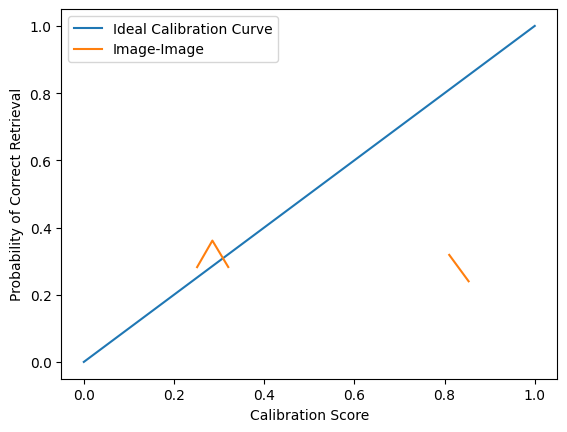

410 187


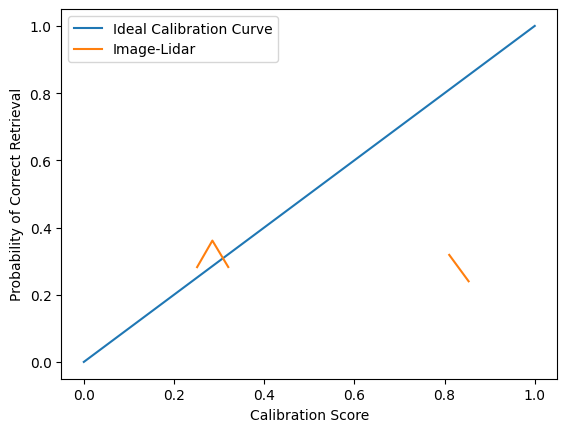

387 210


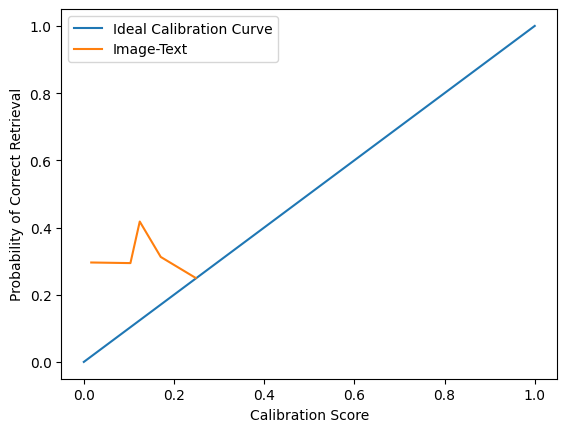

422 175


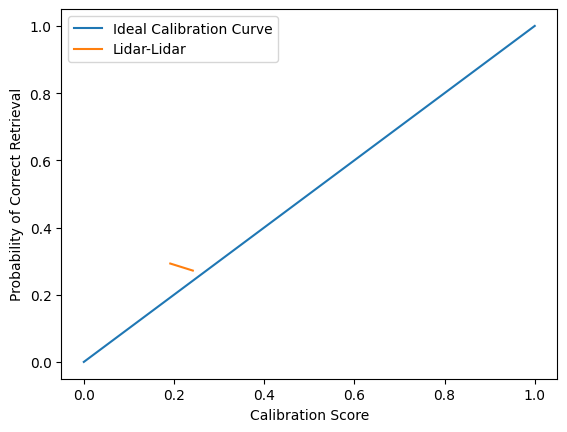

410 187


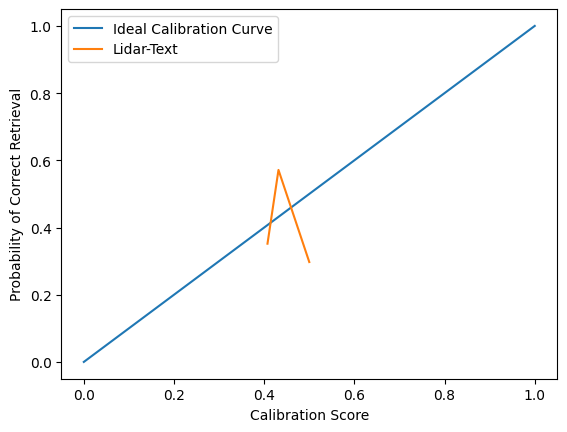

401 196


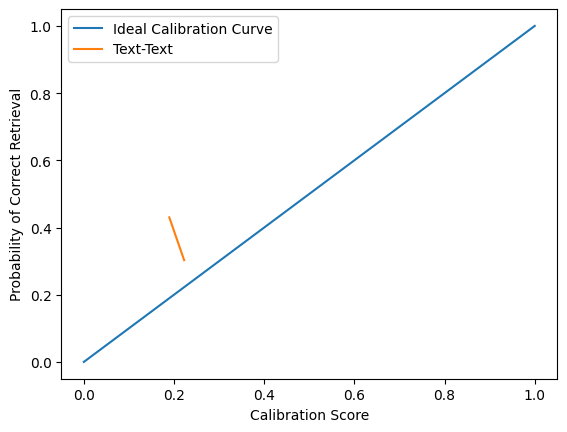

In [7]:
def get_scores_ordered(data: dict, idx_modal1: int, idx_modal2: int,top_k:int = 5)->dict[str, list[tuple[float, int]]]:
    """Get the scores and ground truth for the given modalities."""
    sim_q = {}
    for q, r in data:
        if data[q, r][0][idx_modal1][idx_modal2] >= 1.0 or q == r:
            continue
        if q not in sim_q:
            sim_q[q] = []
        sim_q[q].append((data[q, r][0][idx_modal1][idx_modal2], data[q, r][1]))
        if r not in sim_q:
            sim_q[r] = []
        sim_q[r].append((data[q, r][0][idx_modal1][idx_modal2], data[q, r][1]))
    for q in sim_q:
        sim_q[q] = np.array(sim_q[q])
    for q in sim_q:
        sim_q[q] = sim_q[q][np.argsort(-sim_q[q][:, 0])]
        if sum(sim_q[q][:top_k, 1]) >= 1.0:
            sim_q[q] = (sim_q[q][top_k-1][0], 1)
        else:
            sim_q[q] = (sim_q[q][top_k-1][0], 0)
    return sim_q

def get_nonconformity_scores(q2scores: dict) -> np.ndarray:
    """Get the nonconformity scores for the given modalities."""
    nc_scores = []
    c_scores = []
    for q in q2scores:
        if q2scores[q][1] == 1.0:
            c_scores.append(q2scores[q][0])
        else:
            nc_scores.append(q2scores[q][0])
    return nc_scores, c_scores

def get_scores_and_gt(data: dict, idx_modal1: int, idx_modal2: int) -> tuple[list[float], list[float]]:
    """Get the scores and ground truth for the given modalities."""
    scores = []
    gt = []
    for mat, label in data.values():
        scores.append(mat[idx_modal1][idx_modal2])
        gt.append(label)
    return scores, gt

# plot the calibration curve
# x axis: calibration score
# y axis: percentage of data points in the bin
for i in range(3):
    for j in range(i, 3):
        q2scores = get_scores_ordered(data, i, j, top_k=5)
        nc_scores, c_scores = get_nonconformity_scores(q2scores)
        print(len(nc_scores), len(c_scores))
        scores, gt = [q2scores[q][0] for q in q2scores], [q2scores[q][1] for q in q2scores]
        cali_scores = []
        for score in scores:
            cali_scores.append(calibrate(score, nc_scores))

        # combine score to bins and gt to bins
        bins = np.linspace(0, 1, 20)
        bin_indices = np.digitize(cali_scores, bins)
        bin_scores = []
        bin_gt = []
        for k in range(1, len(bins)):
            bin_mask = bin_indices == k
            bin_scores.append(np.mean(np.array(cali_scores)[bin_mask]))
            bin_gt.append(np.mean(np.array(gt)[bin_mask]))
        plt.figure()
        plt.plot([0,1], [0,1], label="Ideal Calibration Curve")
        plt.plot(bin_scores, bin_gt, label=modalities[i] + "-" + modalities[j])
        plt.xlabel("Calibration Score")
        plt.ylabel("Probability of Correct Retrieval")
        plt.legend()
        plt.show()